***Syntax natürlicher Sprachen, WS 2021/22***

---
# Übung 7 (Lösung)

In [1]:
import nltk
import sys
from IPython.display import display

---
## Aufgabe 1 : FCFG: Kongruenz in Nominalphrasen

#### Orientieren Sie sich an folgender Tabelle zur Mehrdeutigkeit der Formen des bestimmen Artikels im Deutschen und passen Sie die Grammatik unten so an, dass sie nur noch grammatikalisch korrekte Nominalphrasen als Teil von Sätzen akzeptiert. Konzentrieren Sie sich auf die Kongruenz von Artikel und Nomen im Genus.

|Form|mögliche Merkmale|
|----|-----------------|
|der|[NUM=sg, GEN=mas, KAS=nom]|
|&nbsp;|[NUM=sg, GEN=fem, KAS=dat]|
|&nbsp;|[NUM=sg, GEN=fem, KAS=gen]|
|&nbsp;|[NUM=pl, KAS=gen]|
|die|[NUM=sg, GEN=fem, KAS=nom]|
|&nbsp;|[NUM=sg, GEN=fem, KAS=akk]|
|&nbsp;|[NUM=pl, KAS=nom]|
|&nbsp;|[NUM=pl, KAS=akk]|
|das|[NUM=sg, GEN=neu, KAS=nom]|
|&nbsp;|[NUM=sg, GEN=neu, KAS=akk]|

In [2]:
grammar = """
S -> NP VP

NP -> DET[GEN=?x] NOM[GEN=?x]
NOM[GEN=?x] -> ADJ NOM[GEN=?x] | N[GEN=?x]
VP -> V NP NP | V NP | V

ADJ -> "schöne" | "kluge" | "dicke"

DET[GEN=mask] -> "der"
DET[GEN=fem] -> "die"
DET[GEN=neut] -> "das"

N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"

V -> "gibt" | "schenkt" | "schläft" | "gefällt" | "kennt"
"""

In [3]:
def test_grammar(grammar, sentences):
    cfg = nltk.grammar.FeatureGrammar.fromstring(grammar)
    parser = nltk.parse.FeatureEarleyChartParser(cfg)
    
    for i, sent in enumerate(sentences, 1):
        print("Satz {}: {}".format(i, sent))
        results = parser.parse(sent.split())
        analyzed = False
        for tree in results:
            display(tree)
            analyzed = True
        if not analyzed:
            print("Keine Analyse möglich", file=sys.stderr)

In [4]:
pos_sentences = ["der Mann schläft"]
neg_sentences = ["das Mann schläft"]

In [5]:
test_grammar(grammar, neg_sentences)

Satz 1: das Mann schläft


Keine Analyse möglich


Satz 1: der Mann schläft


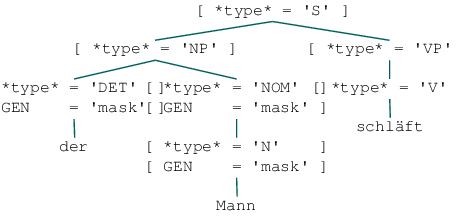

In [6]:
test_grammar(grammar, pos_sentences)

---
## Aufgabe 2: FCFG: Kasus und Subkategorisierung

#### Als nächstes sollen Kasusbedingungen in die Grammatik integriert werden (fügen Sie ggf. neue lexikalische Regeln für die Beispielsätze hinzu):

1. Es gibt nur eine Nominalphrase im Nominativ (Subjekt).
1. Je nach Valenzstellen des Verbes sollen nur Nominalphrasen in den korrekten Kasus akzeptiert werden.
1. *Optional:* Versuchen Sie die freie Satzstellung des Deutschen zu berücksichtigen.

In [7]:
pos_sentences.extend([
    "das Buch gefällt der Frau",
    "das Buch kennt die Frau",
    "der Mann gibt der Frau das Buch"
])

neg_sentences.extend([
    "der Mann schläft das Buch",  #Verletzung Subkategorisierung-Constraint
    "die Frau gefällt das Buch",  #Verletzung Objektkasus-Constraint
    "den Mann schläft",  #Verletzung Subjektkasus-Constraint
    "die Frau gibt das Buch"  #Verletzung Subkategorisierung-Constraint
])

In [8]:
#Lösung für 1 und 2:
grammar = """

S -> NP[CASE=nom] VP

NP[CASE=?y] -> DET[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y]
NOM[GEN=?x,CASE=?y] -> ADJ[GEN=?x,CASE=?y] NOM[GEN=?x]
NOM[GEN=?x] -> N[GEN=?x]

VP -> V[SUBCAT=0]
VP -> V[SUBCAT=1,OBJCASE=?x] NP[CASE=?x]
VP -> V[SUBCAT=2,IOBJCASE=?x,OBJCASE=?y] NP[CASE=?x] NP[CASE=?y]

ADJ[CASE=nom] -> "schöne" | "kluge" | "dicke"
ADJ[CASE=dat] -> "schönen" | "klugen" | "dicken"
ADJ[CASE=akk] -> "schöne" | "kluge" | "dicke"
ADJ[GEN=mask,CASE=akk] -> "schönen" | "klugen" | "dicken"


N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"

V[SUBCAT=0] -> "schläft"
V[SUBCAT=1,OBJCASE=dat] -> "gefällt"
V[SUBCAT=1,OBJCASE=akk] -> "kennt"
V[SUBCAT=2, IOBJCASE=dat, OBJCASE=akk] -> "gibt" | "schenkt"

DET[GEN=mask,CASE=nom] -> "der"
DET[GEN=fem,CASE=dat] -> "der"
DET[GEN=fem,CASE=nom] -> "die"
DET[GEN=fem,CASE=akk] -> "die"
DET[GEN=neut,CASE=nom] -> "das"
DET[GEN=neut,CASE=akk] -> "das"
DET[GEN=mask,CASE=akk] -> "den"
"""

In [9]:
test_grammar(grammar, neg_sentences)

Satz 1: das Mann schläft
Satz 2: der Mann schläft das Buch
Satz 3: die Frau gefällt das Buch
Satz 4: den Mann schläft
Satz 5: die Frau gibt das Buch


Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich


Satz 1: der Mann schläft


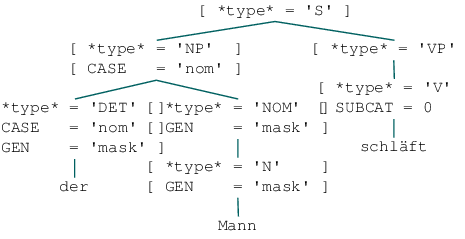

Satz 2: das Buch gefällt der Frau


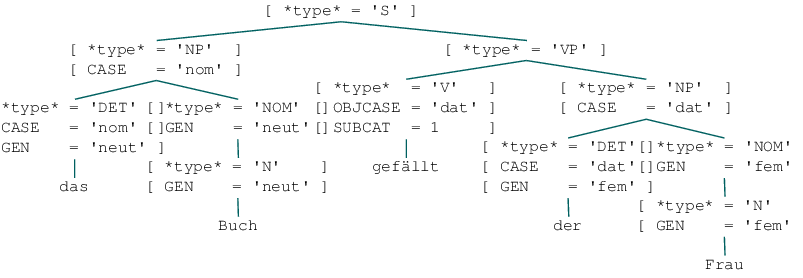

Satz 3: das Buch kennt die Frau


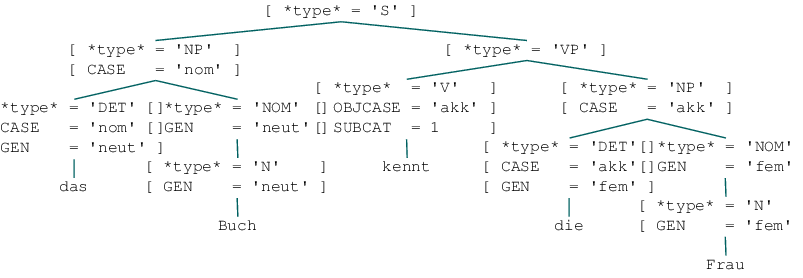

Satz 4: der Mann gibt der Frau das Buch


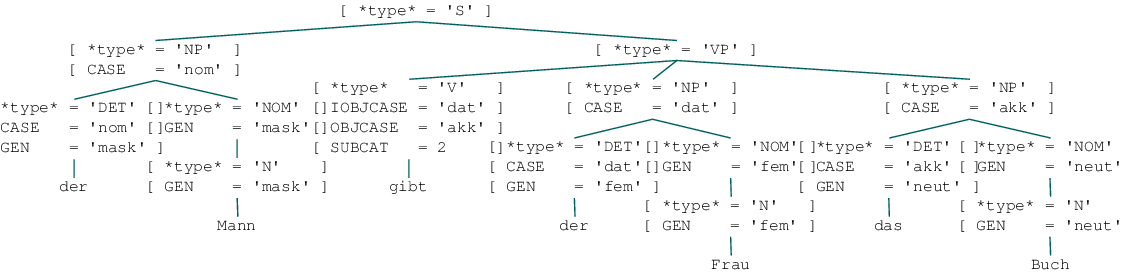

In [10]:
test_grammar(grammar, pos_sentences)

In [11]:
# erweitere Lösung für Bedingung 3 (beliebige NP in Vorfeld = satzinitial):

#    1. Auflösung VP-Struktur (flachere Satzregeln, vgl. TIGER-Treebank)
#    2. zusätzliches SBJCASE-Merkmal

grammar = """

#intransitiv:
S -> NP[CASE=?s] V[SUBCAT=0,SBJCASE=?s]

#transitiv ("die Frau kennt den Mann"  vs  "den Mann kennt die Frau"):
S -> NP[CASE=?s] V[SUBCAT=1,SBJCASE=?s,OBJCASE=?o] NP[CASE=?o]
S -> NP[CASE=?o] V[SUBCAT=1,SBJCASE=?s,OBJCASE=?o] NP[CASE=?s]

#ditransitiv ("der Mann gibt der Frau das Buch" vs "der Mann gibt das Buch der Frau")
S -> NP[CASE=?s] V[SUBCAT=2,SBJCASE=?s,IOBJCASE=?io,OBJCASE=?o] NP[CASE=?io] NP[CASE=?o]
S -> NP[CASE=?s] V[SUBCAT=2,SBJCASE=?s,IOBJCASE=?io,OBJCASE=?o] NP[CASE=?o] NP[CASE=?io]

#ditransitiv ("der Frau gibt der Mann das Buch" vs "das Buch gibt der Mann der Frau"):
S -> NP[CASE=?io] V[SUBCAT=2,SBJCASE=?s,IOBJCASE=?io,OBJCASE=?o] NP[CASE=?s] NP[CASE=?o]
S -> NP[CASE=?o] V[SUBCAT=2,SBJCASE=?s,IOBJCASE=?io,OBJCASE=?o] NP[CASE=?s] NP[CASE=?io]


NP[CASE=?y] -> DET[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y]
NOM[GEN=?x,CASE=?y] -> ADJ[GEN=?x,CASE=?y] NOM[GEN=?x]
NOM[GEN=?x] -> N[GEN=?x]


ADJ[CASE=nom] -> "schöne" | "kluge" | "dicke"
ADJ[CASE=dat] -> "schönen" | "klugen" | "dicken"
ADJ[CASE=akk] -> "schöne" | "kluge" | "dicke"
ADJ[GEN=mask,CASE=akk] -> "schönen" | "klugen" | "dicken"


N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"

V[SUBCAT=0,SBJCASE=nom] -> "schläft"
V[SUBCAT=1,SBJCASE=nom,OBJCASE=dat] -> "gefällt"
V[SUBCAT=1,SBJCASE=nom,OBJCASE=akk] -> "kennt"
V[SUBCAT=2,SBJCASE=nom, IOBJCASE=dat, OBJCASE=akk] -> "gibt" | "schenkt"

DET[GEN=mask,CASE=nom] -> "der"
DET[GEN=fem,CASE=dat] -> "der"
DET[GEN=fem,CASE=nom] -> "die"
DET[GEN=fem,CASE=akk] -> "die"
DET[GEN=neut,CASE=nom] -> "das"
DET[GEN=neut,CASE=akk] -> "das"
DET[GEN=mask,CASE=akk] -> "den"
"""

In [12]:
test_grammar(grammar, neg_sentences)

Satz 1: das Mann schläft
Satz 2: der Mann schläft das Buch
Satz 3: die Frau gefällt das Buch
Satz 4: den Mann schläft
Satz 5: die Frau gibt das Buch


Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich


Satz 1: den Mann kennt die Frau


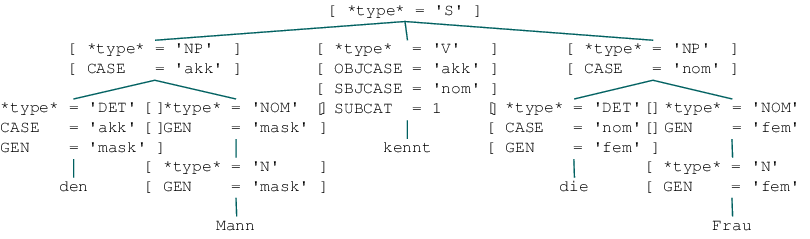

In [13]:
test_grammar(grammar, ["den Mann kennt die Frau"])

Satz 1: die Frau kennt der Mann


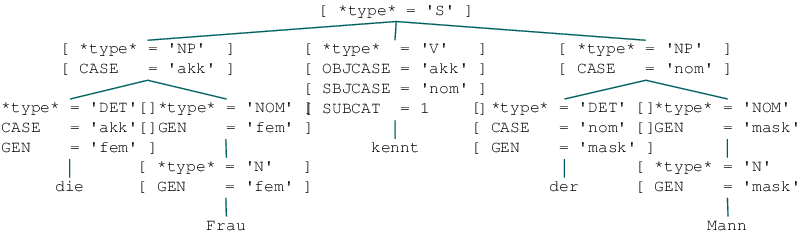

In [14]:
test_grammar(grammar, ["die Frau kennt der Mann"])

Satz 1: der Frau gibt der Mann das Buch


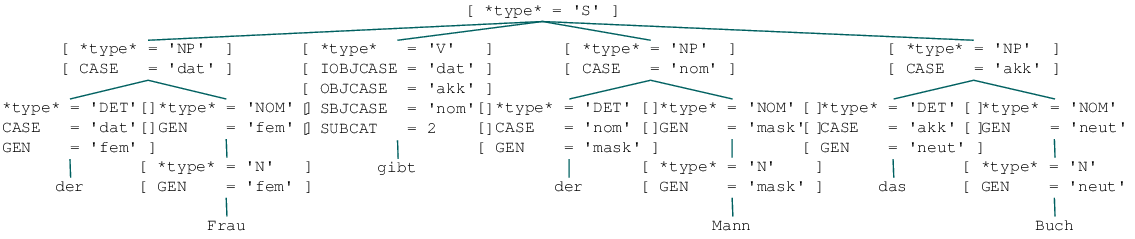

In [15]:
test_grammar(grammar, ["der Frau gibt der Mann das Buch"])

Satz 1: der Mann schläft


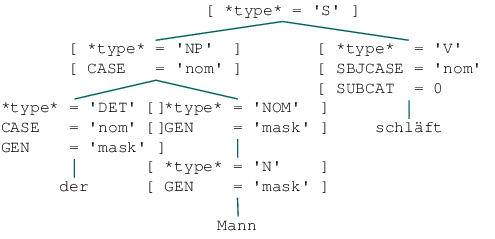

Satz 2: das Buch gefällt der Frau


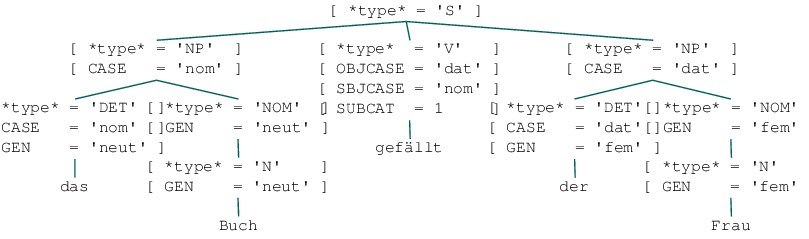

Satz 3: das Buch kennt die Frau


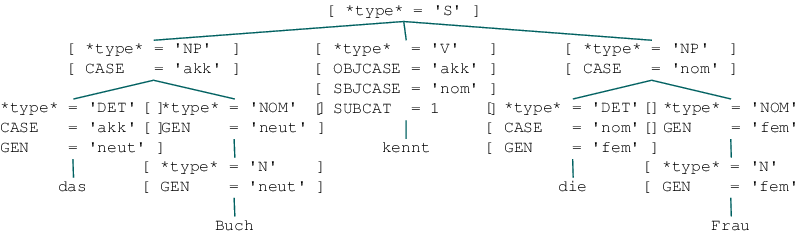

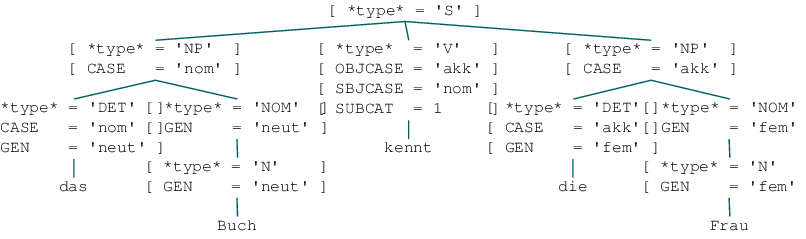

Satz 4: der Mann gibt der Frau das Buch


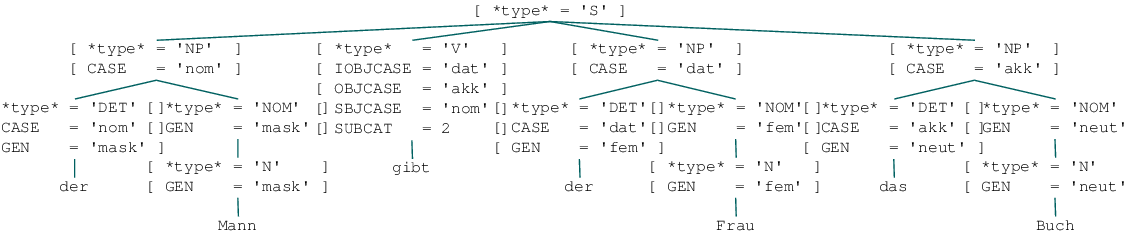

In [16]:
test_grammar(grammar, pos_sentences)

In [17]:
# Alternative Lösung A für Bedingung 3 mit INV-Merkmal und Slash-Kategorie (Gap-Merkmal):

#1. invertierte VP bei transitiven Verben: (NP V)=VP NP
#2. Slash-Kategorie für die an das Satzende gestellte Objekt-NP bzw. Indirekt-Objekt-NP in ditransitiven Sätzen

grammar = """

S -> NP[CASE=nom] VP

#####Regeln für invertierte transitive Sätze (ohne Slash-Feature, nur Wortstellung in VP vertauscht):
S -> VP[+INV] NP[CASE=nom]
VP[+INV] -> NP[CASE=?x] V[SUBCAT=1,OBJCASE=?x]

#####Regeln für invertierte ditransitive Sätze (mit Slash-Kategorie für long distance dependency am Satzende):
S -> VP[+INV]/NP[CASE=?x] NP[CASE=nom] NP[CASE=?x]
VP[+INV]/NP[CASE=?io] -> NP/NP[CASE=?io] NP[CASE=?o] V[SUBCAT=2,IOBJCASE=?io,OBJCASE=?o] 
VP[+INV]/NP[CASE=?o] -> NP[CASE=?io] NP/NP[CASE=?o] V[SUBCAT=2,IOBJCASE=?io,OBJCASE=?o] 
NP/NP -> 


NP[CASE=?y] -> DET[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y]
NOM[GEN=?x,CASE=?y] -> ADJ[GEN=?x,CASE=?y] NOM[GEN=?x]
NOM[GEN=?x] -> N[GEN=?x]

VP -> V[SUBCAT=0]
VP -> V[SUBCAT=1,OBJCASE=?x] NP[CASE=?x]
VP -> V[SUBCAT=2,IOBJCASE=?x,OBJCASE=?y] NP[CASE=?x] NP[CASE=?y]

ADJ[CASE=nom] -> "schöne" | "kluge" | "dicke"
ADJ[CASE=dat] -> "schönen" | "klugen" | "dicken"
ADJ[CASE=akk] -> "schöne" | "kluge" | "dicke"
ADJ[GEN=mask,CASE=akk] -> "schönen" | "klugen" | "dicken"


N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"

V[SUBCAT=0] -> "schläft"
V[SUBCAT=1,OBJCASE=dat] -> "gefällt"
V[SUBCAT=1,OBJCASE=akk] -> "kennt"
V[SUBCAT=2, IOBJCASE=dat, OBJCASE=akk] -> "gibt" | "schenkt"

DET[GEN=mask,CASE=nom] -> "der"
DET[GEN=fem,CASE=dat] -> "der"
DET[GEN=fem,CASE=nom] -> "die"
DET[GEN=fem,CASE=akk] -> "die"
DET[GEN=neut,CASE=nom] -> "das"
DET[GEN=neut,CASE=akk] -> "das"
DET[GEN=mask,CASE=akk] -> "den"
"""

Satz 1: der Mann gibt der Frau das Buch


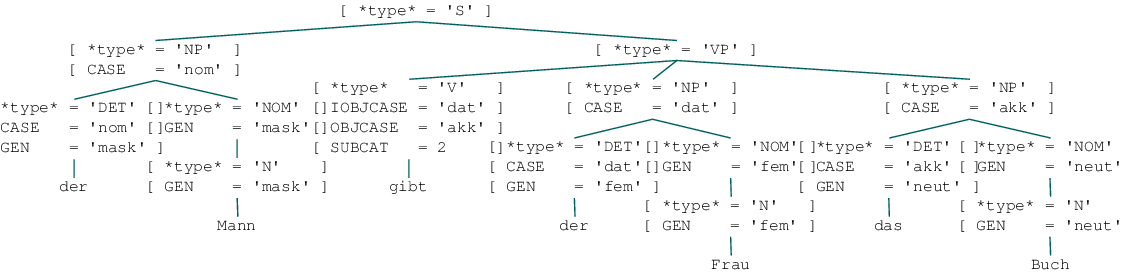

In [18]:
test_grammar(grammar, ["der Mann gibt der Frau das Buch"])

Satz 1: der Frau gibt der Mann das Buch


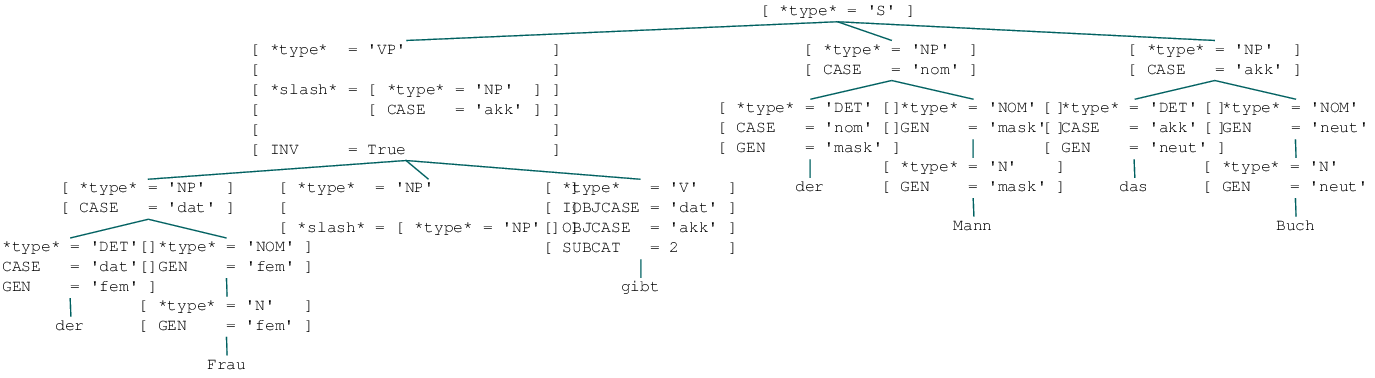

In [19]:
test_grammar(grammar, ["der Frau gibt der Mann das Buch"])

Satz 1: das Buch gibt der Mann der Frau


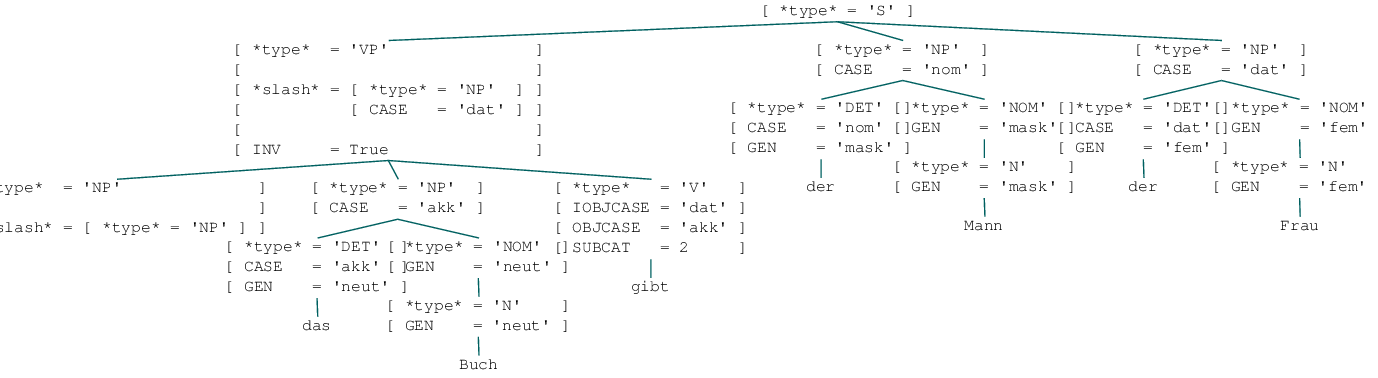

In [20]:
test_grammar(grammar, ["das Buch gibt der Mann der Frau"])

Satz 1: den Mann kennt die Frau


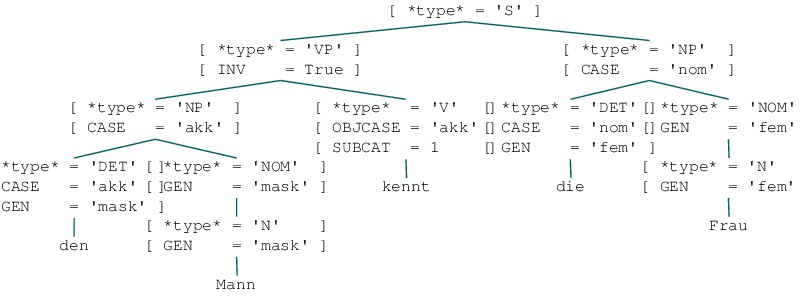

In [21]:
test_grammar(grammar, ["den Mann kennt die Frau"])

Satz 1: die Frau kennt den Mann


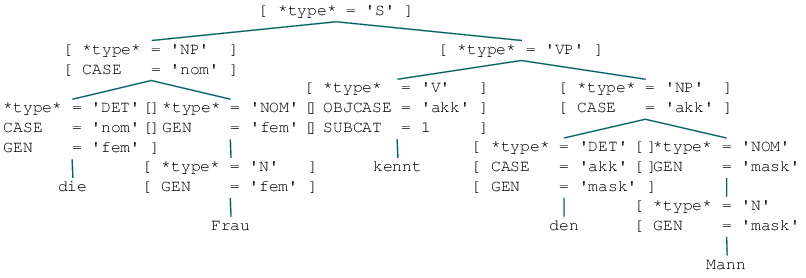

In [22]:
test_grammar(grammar, ["die Frau kennt den Mann"])

In [23]:
test_grammar(grammar, ["die Frau gefällt den Mann"])

Satz 1: die Frau gefällt den Mann


Keine Analyse möglich


Satz 1: der Frau gefällt das Buch


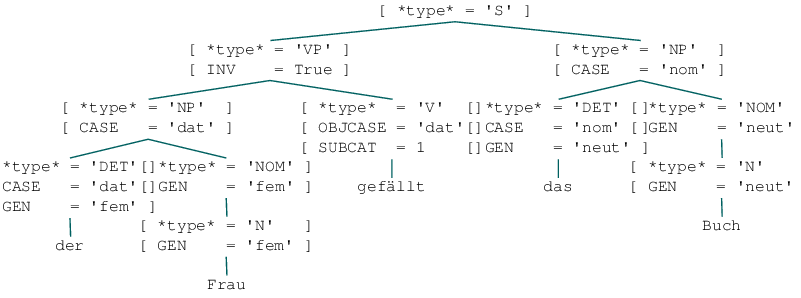

In [24]:
test_grammar(grammar, ["der Frau gefällt das Buch"])

Satz 1: das Buch gefällt der Frau


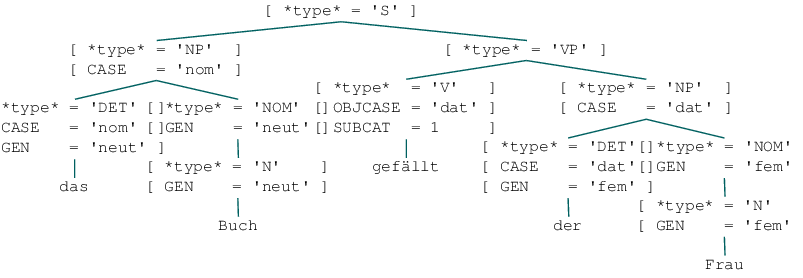

In [25]:
test_grammar(grammar, ["das Buch gefällt der Frau"])

In [26]:
# Alternative Lösung B für Bedingung 3 mit Slash-Kategorien für transitiven und ditransitive Sätze:


grammar = """

S -> NP[CASE=nom] VP

#####Regeln für invertierte transitive Sätze:
S -> NP[CASE=?x] VP/NP[CASE=?x] NP[CASE=nom] 
VP/NP[CASE=?o] ->  V[SUBCAT=1,OBJCASE=?o] NP/NP[CASE=?o] 
NP/NP -> 

#####Regeln für invertierte ditransitive Sätze:
S -> NP[CASE=?x] VP/NP[CASE=?x]/NP[CASE=?y] NP[CASE=nom] NP[CASE=?y]
VP/NP[CASE=?io]/NP[CASE=?o] -> V[SUBCAT=2,IOBJCASE=?io,OBJCASE=?o] NP/NP[CASE=?io] NP/NP[CASE=?o] 
VP/NP[CASE=?o]/NP[CASE=?io] -> V[SUBCAT=2,IOBJCASE=?io,OBJCASE=?o] NP/NP[CASE=?o] NP/NP[CASE=?io]
NP/NP -> 


NP[CASE=?y] -> DET[GEN=?x,CASE=?y] NOM[GEN=?x,CASE=?y]
NOM[GEN=?x,CASE=?y] -> ADJ[GEN=?x,CASE=?y] NOM[GEN=?x]
NOM[GEN=?x] -> N[GEN=?x]

VP -> V[SUBCAT=0]
VP -> V[SUBCAT=1,OBJCASE=?x] NP[CASE=?x]
VP -> V[SUBCAT=2,IOBJCASE=?x,OBJCASE=?y] NP[CASE=?x] NP[CASE=?y]

ADJ[CASE=nom] -> "schöne" | "kluge" | "dicke"
ADJ[CASE=dat] -> "schönen" | "klugen" | "dicken"
ADJ[CASE=akk] -> "schöne" | "kluge" | "dicke"
ADJ[GEN=mask,CASE=akk] -> "schönen" | "klugen" | "dicken"


N[GEN=mask] -> "Mann"
N[GEN=fem] -> "Frau"
N[GEN=neut] -> "Buch"

V[SUBCAT=0] -> "schläft"
V[SUBCAT=1,OBJCASE=dat] -> "gefällt"
V[SUBCAT=1,OBJCASE=akk] -> "kennt"
V[SUBCAT=2, IOBJCASE=dat, OBJCASE=akk] -> "gibt" | "schenkt"

DET[GEN=mask,CASE=nom] -> "der"
DET[GEN=fem,CASE=dat] -> "der"
DET[GEN=fem,CASE=nom] -> "die"
DET[GEN=fem,CASE=akk] -> "die"
DET[GEN=neut,CASE=nom] -> "das"
DET[GEN=neut,CASE=akk] -> "das"
DET[GEN=mask,CASE=akk] -> "den"
"""

Satz 1: der Mann gibt der Frau das Buch


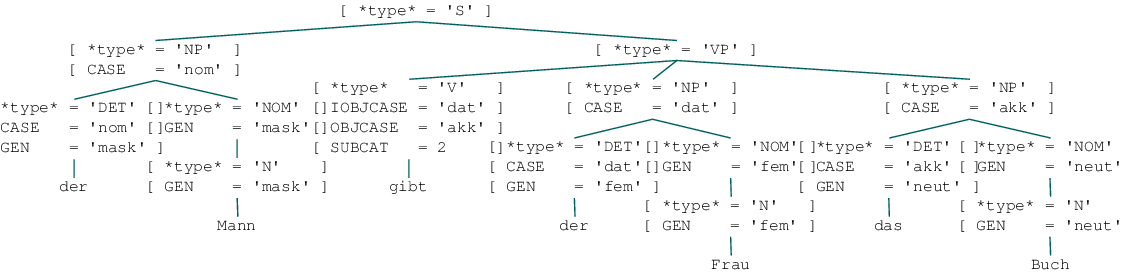

In [27]:
test_grammar(grammar, ["der Mann gibt der Frau das Buch"])

Satz 1: der Frau gibt der Mann das Buch


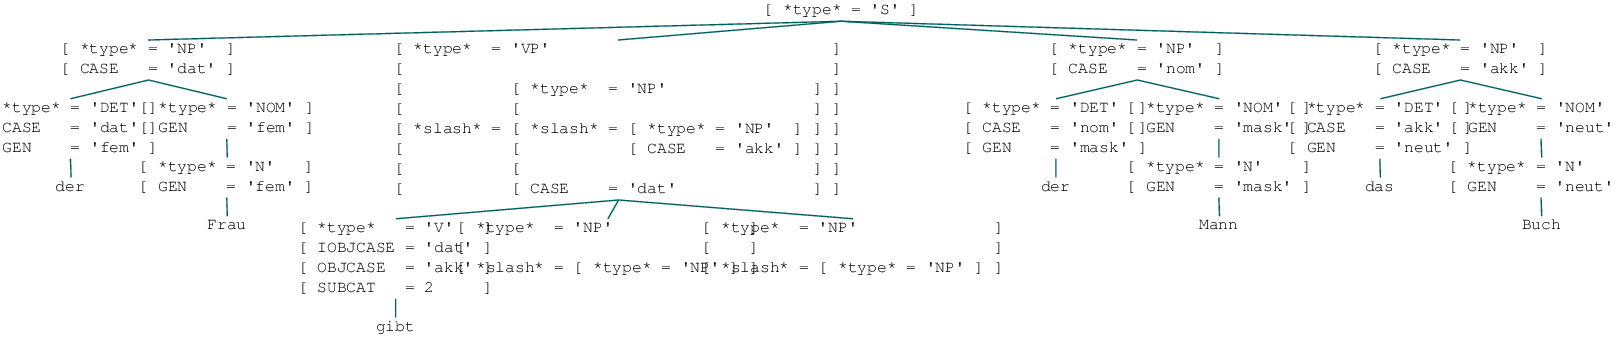

In [28]:
test_grammar(grammar, ["der Frau gibt der Mann das Buch"])

Satz 1: das Buch gibt der Mann der Frau


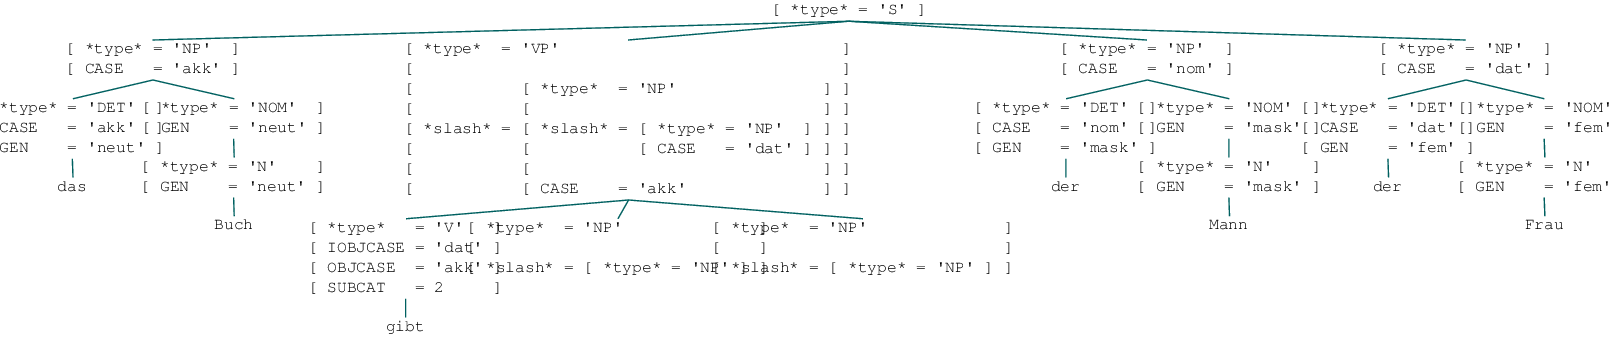

In [29]:
test_grammar(grammar, ["das Buch gibt der Mann der Frau"])

Satz 1: den Mann kennt die Frau


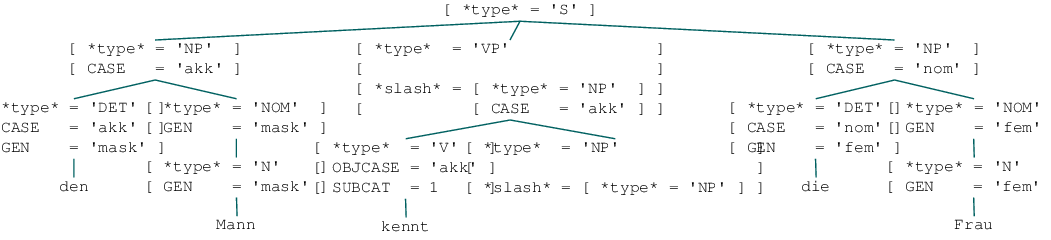

In [30]:
test_grammar(grammar, ["den Mann kennt die Frau"])

Satz 1: die Frau kennt den Mann


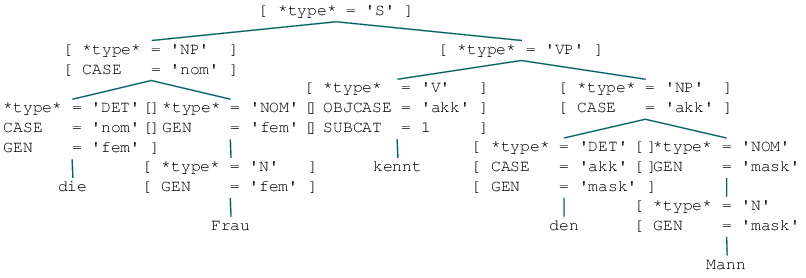

In [31]:
test_grammar(grammar, ["die Frau kennt den Mann"])

In [32]:
test_grammar(grammar, ["die Frau gefällt den Mann"])

Satz 1: die Frau gefällt den Mann


Keine Analyse möglich


Satz 1: der Frau gefällt das Buch


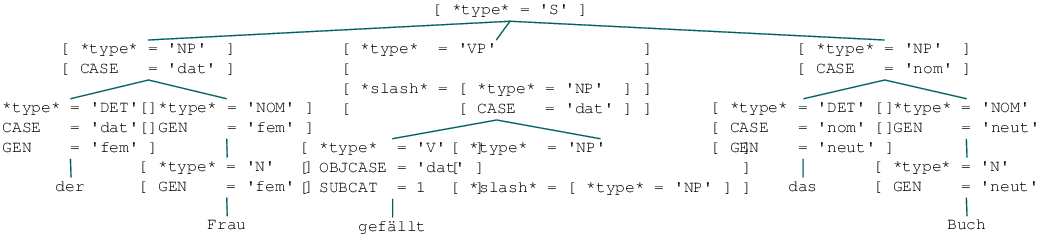

In [33]:
test_grammar(grammar, ["der Frau gefällt das Buch"])

Satz 1: das Buch gefällt der Frau


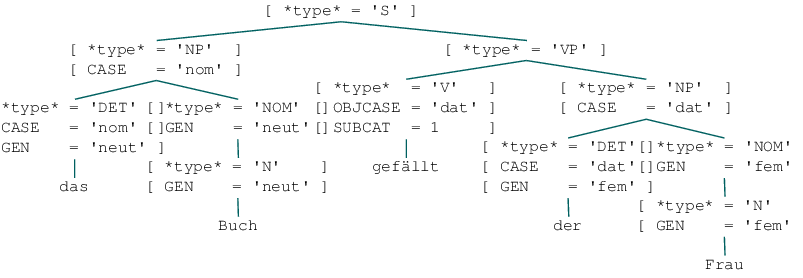

In [34]:
test_grammar(grammar, ["das Buch gefällt der Frau"])

---
## Aufgabe 3: Plural-Agreement für Subjekt und Verb

#### Ergänzen Sie die untenstehende Grammatik um die Möglichkeit, das Subjekt in den Plural zu setzen.

#### Dafür müssen Sie folgendes tun:
  1. Erstellen Sie lexikalische Regeln für Pluralformen der Verben, Adjektive und Substantive (Nominativ ist ausreichend.).
  1. Vervollständigen Sie die lexikalischen Regeln für die Form des Artikels *die* um die korrekte Merkmalstruktur für den Plural.
  1. Formulieren Sie eine Kongruenzbedingung in Numerus zwischen Verb und Subjekt.

In [35]:
grammar = """

S -> NP[CASE=nom,NUM=?x] VP[NUM=?x]

NP[CASE=?y,NUM=?z] -> DET[GEN=?x,CASE=?y,NUM=?z] NOM[GEN=?x,NUM=?z]
NOM[GEN=?x,NUM=?z] -> ADJ[NUM=?z] NOM[GEN=?x,NUM=?z]
NOM[GEN=?x,NUM=?z] -> N[GEN=?x,NUM=?z]

VP[NUM=?z] -> V[SUBCAT=intr,NUM=?z]
VP[NUM=?z] -> V[SUBCAT=tr,OBJCASE=?x,NUM=?z] NP[CASE=?x]
VP[NUM=?z] -> V[SUBCAT=ditr,OBJCASE1=?x,OBJCASE2=?y,NUM=?z] NP[CASE=?x] NP[CASE=?y]

ADJ[NUM=sg] -> "schöne" | "kluge" | "dicke"
ADJ[NUM=pl] -> "schönen" | "klugen" | "dicken"

N[GEN=mask,NUM=sg] -> "Mann"
N[GEN=mask,NUM=pl] -> "Männer"
N[GEN=fem,NUM=sg] -> "Frau"
N[GEN=fem,NUM=pl] -> "Frauen"
N[GEN=neut,NUM=sg] -> "Buch"
N[GEN=neut,NUM=pl] -> "Bücher"

V[SUBCAT=intr,NUM=sg] -> "schläft"
V[SUBCAT=intr,NUM=pl] -> "schlafen"
V[SUBCAT=tr,OBJCASE=dat,NUM=sg] -> "gefällt"
V[SUBCAT=tr,OBJCASE=dat,NUM=pl] -> "gefallen"
V[SUBCAT=tr,OBJCASE=akk,NUM=sg] -> "kennt"
V[SUBCAT=tr,OBJCASE=akk,NUM=pl] -> "kennen"
V[SUBCAT=ditr, OBJCASE1=dat, OBJCASE2=akk,NUM=sg] -> "gibt" | "schenkt"
V[SUBCAT=ditr, OBJCASE1=dat, OBJCASE2=akk,NUM=pl] -> "geben" | "schenken"

DET[GEN=mask,CASE=nom,NUM=sg] -> "der"
DET[GEN=fem,CASE=dat,NUM=sg] -> "der"
DET[GEN=fem,CASE=nom,NUM=sg] -> "die"
DET[GEN=fem,CASE=akk,NUM=sg] -> "die"
DET[GEN=neut,CASE=nom,NUM=sg] -> "das"
DET[GEN=neut,CASE=akk,NUM=sg] -> "das"

DET[CASE=nom,NUM=pl] -> "die"
DET[CASE=akk,NUM=pl] -> "die"
"""

In [36]:
#alternative Lösung mit komplexem AGR-Feature:
grammar = """

S -> NP[CASE=nom,AGR=?x] VP[AGR=?x]

NP[CASE=?y,AGR=?x] -> DET[CASE=?y,AGR=?x] NOM[AGR=?x]
NOM[AGR=?x] -> ADJ[AGR=?x] NOM[AGR=?x]
NOM[AGR=?x] -> N[AGR=?x]

VP[AGR=?x] -> V[SUBCAT=intr,AGR=?x]
VP[AGR=?x] -> V[SUBCAT=tr,OBJCASE=?o,AGR=?x] NP[CASE=?o]
VP[AGR=?x] -> V[SUBCAT=ditr,OBJCASE1=?io,OBJCASE2=?o,AGR=?x] NP[CASE=?io] NP[CASE=?o]

ADJ[AGR=[NUM=sg]] -> "schöne" | "kluge" | "dicke"
ADJ[AGR=[NUM=pl]] -> "schönen" | "klugen" | "dicken"

N[AGR=[GEN=mask,NUM=sg]] -> "Mann"
N[AGR=[GEN=mask,NUM=pl]] -> "Männer"
N[AGR=[GEN=fem,NUM=sg]] -> "Frau"
N[AGR=[GEN=fem,NUM=pl]] -> "Frauen"
N[AGR=[GEN=neut,NUM=sg]] -> "Buch"
N[AGR=[GEN=neut,NUM=pl]] -> "Bücher"

V[SUBCAT=intr,AGR=[NUM=sg]] -> "schläft"
V[SUBCAT=intr,AGR=[NUM=pl]] -> "schlafen"
V[SUBCAT=tr,OBJCASE=dat,AGR=[NUM=sg]] -> "gefällt"
V[SUBCAT=tr,OBJCASE=dat,AGR=[NUM=pl]] -> "gefallen"
V[SUBCAT=tr,OBJCASE=akk,AGR=[NUM=sg]] -> "kennt"
V[SUBCAT=tr,OBJCASE=akk,AGR=[NUM=pl]] -> "kennen"
V[SUBCAT=ditr, OBJCASE1=dat, OBJCASE2=akk,AGR=[NUM=sg]] -> "gibt" | "schenkt"
V[SUBCAT=ditr, OBJCASE1=dat, OBJCASE2=akk,AGR=[NUM=pl]] -> "geben" | "schenken"

DET[CASE=nom,AGR=[GEN=mask,NUM=sg]] -> "der"
DET[CASE=dat,AGR=[GEN=fem,NUM=sg]] -> "der"
DET[CASE=nom,AGR=[GEN=fem,NUM=sg]] -> "die"
DET[CASE=akk,AGR=[GEN=fem,NUM=sg]] -> "die"
DET[CASE=nom,AGR=[GEN=neut,NUM=sg]] -> "das"
DET[CASE=akk,AGR=[GEN=neut,NUM=sg]] -> "das"

DET[CASE=nom,AGR=[NUM=pl]] -> "die"
DET[CASE=akk,AGR=[NUM=pl]] -> "die"
"""

In [37]:
pos_sentences = [
    "die Männer geben der Frau das Buch",
    "die Bücher gefallen der Frau",
    "die Frauen schlafen"
]

neg_sentences = [
    "der Mann geben der Frau das Buch",
    "das Buch gefällt der Frauen",
    "die Frauen schläft"
]

Satz 1: die Männer geben der Frau das Buch


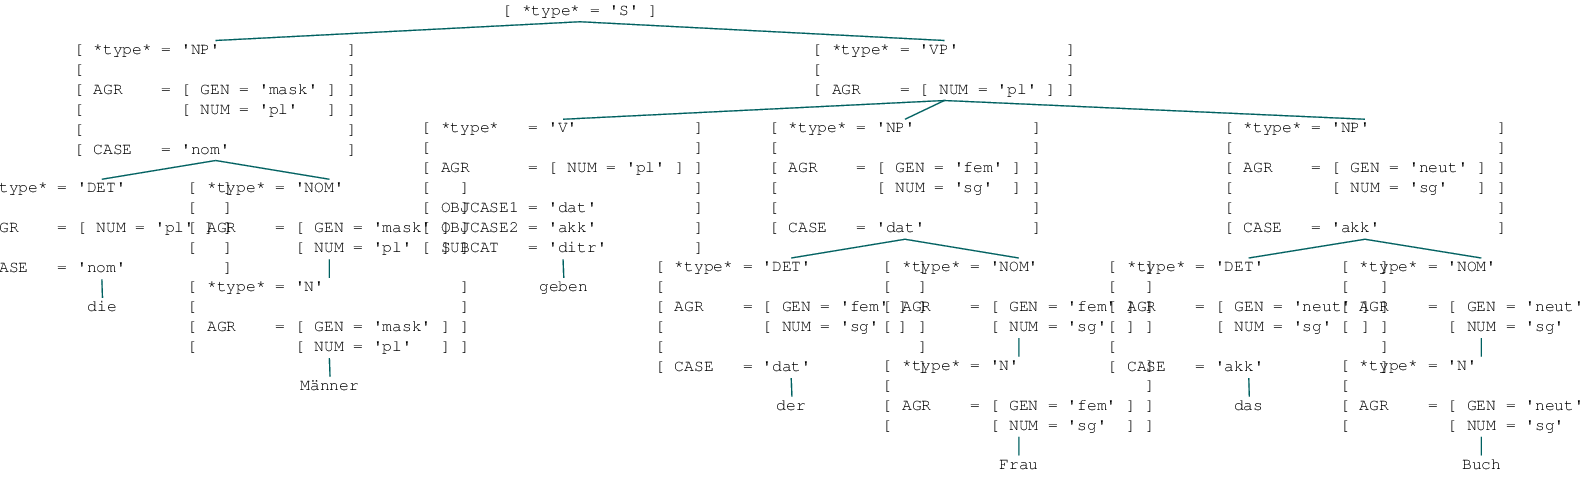

Satz 2: die Bücher gefallen der Frau


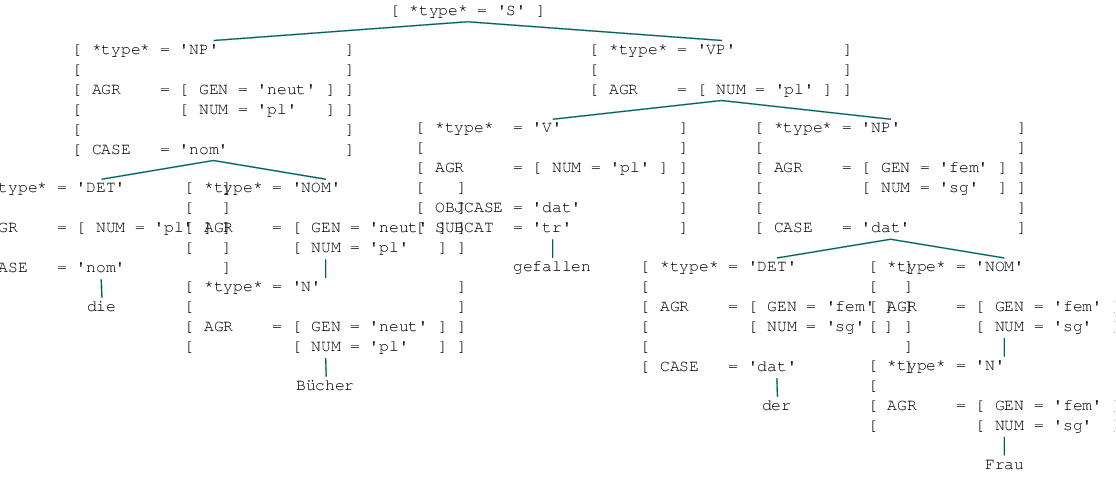

Satz 3: die Frauen schlafen


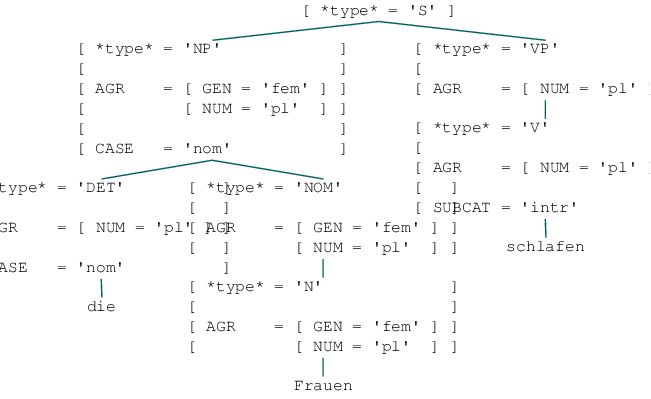

In [38]:
test_grammar(grammar, pos_sentences)

In [39]:
test_grammar(grammar, neg_sentences)

Satz 1: der Mann geben der Frau das Buch
Satz 2: das Buch gefällt der Frauen
Satz 3: die Frauen schläft


Keine Analyse möglich
Keine Analyse möglich
Keine Analyse möglich


--- 
# Hausaufgaben

---
## Aufgabe 4: Adverben und Verbzweitstellung

#### Fügen Sie der Grammatik jetzt die zwei Adverben *heute* und *morgen* hinzu. Adverben können prinzipiell sehr frei im Satz platziert werden. Eine Besonderheit des Deutschen ist aber die sog. Verbzweitstellung, wie sie z. B. in Sätzen wie *Heute schläft der Mann.* deutlich wird.
#### Versuchen Sie alle Möglichkeiten zu implementieren:

In [41]:
grammar = """

#intransitiv:
S -> ADV V[SUBCAT=intr,NUM=?x] NP[CASE=nom,NUM=?x]
S -> NP[CASE=nom,NUM=?x] V[SUBCAT=intr,NUM=?x] ADV

#transitiv:
S -> ADV V[SUBCAT=tr,OBJCASE=?o,NUM=?x] NP[CASE=nom,NUM=?x] NP[CASE=?o,NUM=?x] 
S -> NP[CASE=nom,NUM=?x] V[SUBCAT=tr,OBJCASE=?o,NUM=?x] ADV NP[CASE=?o,NUM=?x]
S -> NP[CASE=?o,NUM=?x] V[SUBCAT=tr,OBJCASE=?o,NUM=?x] NP[CASE=nom,NUM=?x] ADV 


#ditransitiv:
S -> ADV V[SUBCAT=ditr,OBJCASE1=?io,OBJCASE2=?o,NUM=?x] NP[CASE=nom,NUM=?x] NP[CASE=?io,NUM=?x] NP[CASE=?o,NUM=?x] 
S -> NP[CASE=nom,NUM=?x] V[SUBCAT=ditr,OBJCASE1=?io,OBJCASE2=?o,NUM=?x] ADV NP[CASE=?io,NUM=?x] NP[CASE=?o,NUM=?x] 
S -> NP[CASE=nom,NUM=?x] V[SUBCAT=ditr,OBJCASE1=?io,OBJCASE2=?o,NUM=?x] NP[CASE=?io,NUM=?x] ADV NP[CASE=?o,NUM=?x] 
S -> NP[CASE=nom,NUM=?x] V[SUBCAT=ditr,OBJCASE1=?io,OBJCASE2=?o,NUM=?x] NP[CASE=?io,NUM=?x] NP[CASE=?o,NUM=?x] ADV
#usw. (s.o. Aufgabe 2) 

NP[CASE=?y,NUM=?z] -> DET[GEN=?x,CASE=?y,NUM=?z] NOM[GEN=?x,NUM=?z]
NOM[GEN=?x,NUM=?z] -> ADJ[NUM=?z] NOM[GEN=?x,NUM=?z]
NOM[GEN=?x,NUM=?z] -> N[GEN=?x,NUM=?z]


ADV -> "heute" | "morgen"

ADJ[NUM=sg] -> "schöne" | "kluge" | "dicke"
ADJ[NUM=pl] -> "schönen" | "klugen" | "dicken"

N[GEN=mask,NUM=sg] -> "Mann"
N[GEN=mask,NUM=pl] -> "Männer"
N[GEN=fem,NUM=sg] -> "Frau"
N[GEN=fem,NUM=pl] -> "Frauen"
N[GEN=neut,NUM=sg] -> "Buch"
N[GEN=neut,NUM=pl] -> "Bücher"

V[SUBCAT=ditr, OBJCASE1=dat, OBJCASE2=akk,NUM=sg] -> "gibt" | "schenkt"
V[SUBCAT=ditr, OBJCASE1=dat, OBJCASE2=akk,NUM=pl] -> "geben" | "schenken"
V[SUBCAT=intr,NUM=sg] -> "schläft"
V[SUBCAT=intr,NUM=pl] -> "schlafen"
V[SUBCAT=tr,OBJCASE=dat,NUM=sg] -> "gefällt"
V[SUBCAT=tr,OBJCASE=dat,NUM=pl] -> "gefallen"
V[SUBCAT=tr,OBJCASE=akk,NUM=sg] -> "kennt"
V[SUBCAT=tr,OBJCASE=akk,NUM=pl] -> "kennen"

DET[GEN=mask,CASE=nom,NUM=sg] -> "der"
DET[GEN=fem,CASE=dat,NUM=sg] -> "der"

DET[GEN=fem,CASE=nom,NUM=sg] -> "die"
DET[GEN=fem,CASE=akk,NUM=sg] -> "die"
DET[GEN=neut,CASE=nom,NUM=sg] -> "das"
DET[GEN=neut,CASE=akk,NUM=sg] -> "das"

DET[CASE=nom,NUM=pl] -> "die"
DET[CASE=akk,NUM=pl] -> "die"
"""

In [42]:
pos_sentences = [
  "heute gibt der Mann der Frau das Buch",
  "der Mann gibt heute der Frau das Buch",
  "der Mann gibt der Frau heute das Buch",
  "der Mann gibt der Frau das Buch heute"
]

neg_sentences = [
    "heute der Mann gibt der Frau das Buch"
]

Satz 1: heute gibt der Mann der Frau das Buch


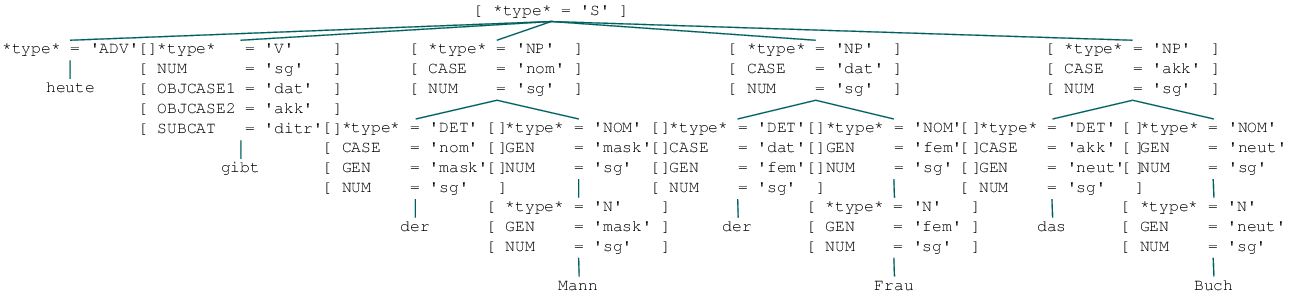

Satz 2: der Mann gibt heute der Frau das Buch


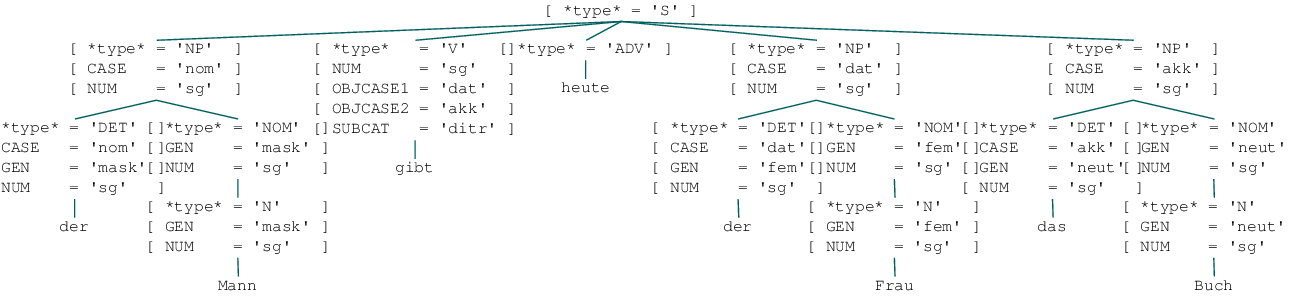

Satz 3: der Mann gibt der Frau heute das Buch


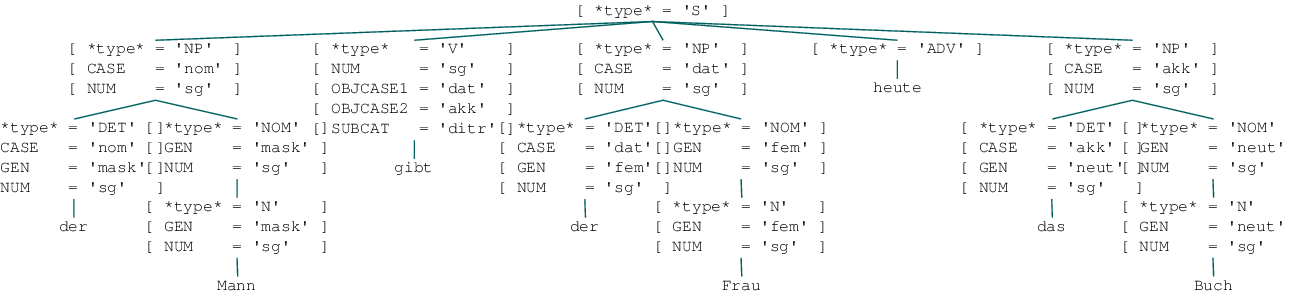

Satz 4: der Mann gibt der Frau das Buch heute


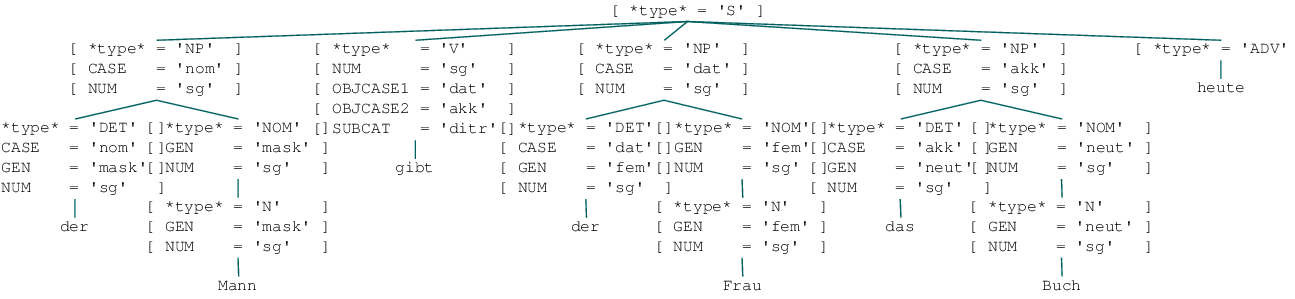

In [43]:
test_grammar(grammar, pos_sentences)

In [44]:
test_grammar(grammar, neg_sentences)

Satz 1: heute der Mann gibt der Frau das Buch


Keine Analyse möglich
